# 01 - EDA and Analysis

**Purpose:**  
This notebook performs Exploratory Data Analysis (EDA) on the cleaned data in `data/processed/`
- discovers available CSVs in `data/raw/` and `data/processed/`
- loads and inspects each file
- computes summary statistics, missingness, and correlations
- calculates engagement metrics and top performers
- writes summary outputs to `data/outputs/`

**Imports and Configurations**

In [35]:
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

**Plot settings**

In [36]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 190)

**Setting up paths**

In [37]:
# Paths (adjust if your structure differs)
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
OUTPUTS_DIR = PROJECT_ROOT / "data" / "outputs"

# Ensure outputs exist
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Notebook working directory:", NOTEBOOK_DIR)
print("Raw dir:", RAW_DIR)
print("Processed dir:", PROCESSED_DIR)
print("Outputs dir:", OUTPUTS_DIR)


Project root: c:\Users\91900\Digicrome_Internship\Project5_Youtube_tiktok\youtube-tiktok-analysis-nagasantoshchavvakula
Notebook working directory: c:\Users\91900\Digicrome_Internship\Project5_Youtube_tiktok\youtube-tiktok-analysis-nagasantoshchavvakula\Notebooks
Raw dir: c:\Users\91900\Digicrome_Internship\Project5_Youtube_tiktok\youtube-tiktok-analysis-nagasantoshchavvakula\data\raw
Processed dir: c:\Users\91900\Digicrome_Internship\Project5_Youtube_tiktok\youtube-tiktok-analysis-nagasantoshchavvakula\data\processed
Outputs dir: c:\Users\91900\Digicrome_Internship\Project5_Youtube_tiktok\youtube-tiktok-analysis-nagasantoshchavvakula\data\outputs


**Discovering Available Datasets**

In [21]:
# Discover CSV files in raw and processed folders
raw_files = sorted(glob.glob(str(RAW_DIR / "*.csv")))
processed_files = sorted(glob.glob(str(PROCESSED_DIR / "*.csv")))

print(f"Found {len(raw_files)} raw file(s) and {len(processed_files)} processed file(s).\n")
if raw_files:
    print("Raw files:")
    for f in raw_files:
        print("  -", Path(f).name)
if processed_files:
    print("\nProcessed/Cleaned files:")
    for f in processed_files:
        print("  -", Path(f).name)


Found 6 raw file(s) and 6 processed file(s).

Raw files:
  - DATA_DICTIONARY.csv
  - country_platform_summary_2025.csv
  - monthly_trends_2025.csv
  - top_creators_impact_2025.csv
  - top_hashtags_2025.csv
  - youtube_shorts_tiktok_trends_2025.csv

Processed/Cleaned files:
  - country_platform_summary_2025_cleaned.csv
  - data_dictionary_cleaned.csv
  - monthly_trends_2025_cleaned.csv
  - top_creators_impact_2025_cleaned.csv
  - top_hashtags_2025_cleaned.csv
  - youtube_shorts_tiktok_trends_2025_cleaned.csv


**Load Multiple Processed Datasets**

In [38]:
def safe_read_csv(path, nrows=None):
    """Try reading CSV with common encodings and return DataFrame or None on failure."""
    encodings = ['utf-8', 'utf-8-sig', 'latin1', 'cp1252']
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc, nrows=nrows)
        except Exception as e:
            last_err = e
    print(f"Failed to read {path!s}: {last_err}")
    return None

def load_all_csvs(filepaths):
    """Load multiple CSVs into dict {basename: df}. Skips files that can't be parsed."""
    dfs = {}
    for p in filepaths:
        name = Path(p).stem
        df = safe_read_csv(p)
        if df is not None:
            dfs[name] = df
    return dfs

# Load processed datasets (limited nrows for quick first-run if needed)
processed_dfs = load_all_csvs(processed_files)
print(f"Loaded {len(processed_dfs)} processed dataset(s): {list(processed_dfs.keys())}")


Loaded 6 processed dataset(s): ['country_platform_summary_2025_cleaned', 'data_dictionary_cleaned', 'monthly_trends_2025_cleaned', 'top_creators_impact_2025_cleaned', 'top_hashtags_2025_cleaned', 'youtube_shorts_tiktok_trends_2025_cleaned']


**Summary of Per file Overview**

In [23]:
# Create a per-file overview DataFrame
summaries = []
for name, df in processed_dfs.items():
    n_rows, n_cols = df.shape
    n_missing = df.isnull().sum().sum()
    col_types = df.dtypes.value_counts().to_dict()
    summaries.append({
        "file": name,
        "rows": n_rows,
        "cols": n_cols,
        "total_nulls": int(n_missing),
        "dtypes_counts": col_types
    })

summary_df = pd.DataFrame(summaries).sort_values("rows", ascending=False)
display(summary_df)


,file,rows,cols,total_nulls,dtypes_counts
5,youtube_shorts_tiktok_trends_2025_cleaned,48079,58,0,"{object: 29, float64: 15, int64: 14}"
3,top_creators_impact_2025_cleaned,1000,20,0,"{float64: 10, int64: 8, object: 2}"
2,monthly_trends_2025_cleaned,480,8,0,"{object: 4, int64: 2, float64: 2}"
4,top_hashtags_2025_cleaned,82,18,0,"{float64: 9, int64: 7, object: 2}"
0,country_platform_summary_2025_cleaned,60,14,0,"{float64: 8, object: 3, int64: 3}"
1,data_dictionary_cleaned,58,2,0,{object: 2}


**Selecting datasets for EDA**

In [43]:
# choose the largest processed dataset as the main table to EDA
if len(processed_dfs) == 0:
    raise FileNotFoundError("No processed CSVs found in data/processed/. Run the pipeline scripts first.")

# pick dataset with most rows
main_name = summary_df.iloc[0]["file"]
df = processed_dfs[main_name].copy()
print(f"Using '{main_name}' as main dataset for EDA (rows={df.shape[0]}, cols={df.shape[1]})")


Using 'youtube_shorts_tiktok_trends_2025_cleaned' as main dataset for EDA (rows=48079, cols=58)


**DataFrame Basic Inspection**

In [44]:
# Basic inspection
print("Shape:", df.shape)
display(df.head(10))
print("\nDtypes:")
display(df.dtypes)
print("\nBasic describe (numeric):")
display(df.describe(include=[np.number]).T)

# Missingness per column
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_percent], axis=1)
missing_df.columns = ["null_count", "null_pct"]
display(missing_df[missing_df["null_count"] > 0])


Shape: (48079, 58)


,platform,country,region,language,category,hashtag,title_keywords,author_handle,sound_type,music_track,week_of_year,duration_sec,views,likes,comments,shares,saves,engagement_rate,trend_label,source_hint,notes,device_type,upload_hour,genre,trend_duration_days,trend_type,engagement_velocity,dislikes,comment_ratio,share_rate,save_rate,like_dislike_ratio,publish_dayofweek,publish_period,event_season,tags,sample_comments,creator_avg_views,creator_tier,season,publish_date_approx,year_month,title,title_length,has_emoji,avg_watch_time_sec,completion_rate,device_brand,traffic_source,is_weekend,row_id,engagement_total,like_rate,dislike_rate,engagement_per_1k,engagement_like_rate,engagement_comment_rate,engagement_share_rate
0,TikTok,Jp,Asia,ja,Gaming,#Lifestyle,Night Routine — College,NextVision,trending,8bit loop,1,40,252497,21755,3170,1977,3415,0.120069,rising,TikTok Creative Center,split-screen,Android,15,Lifestyle,4,Short,63124.25,1011,0.012555,0.007830,0.013525,21.497036,Saturday,Afternoon,Regular,"daily, lifestyle, motivation",ずっと見ちゃう😂,96474.3,Mid,Spring,2025-01-04,2025-01,Night Routine — Productivity 🏖️,31,1,25.8,0.645,iPhone,External,1,2e681528d17a1fe1986857942536ec27,30317,0.086159,0.004004,120.069,0.086159,0.012555,0.007830
1,TikTok,Se,Europe,sv,Food,#Sports,Morning Routine — College,DailyVlogsDiego,trending,Street vibe,1,18,270580,23080,2124,2108,3265,0.113005,declining,TikTok Creative Center,greenscreen,Android,3,Sports,56,Evergreen,4831.79,655,0.007850,0.007791,0.012067,35.182927,Wednesday,Night,Regular,"gym, football, workout",This is fire 🔥,104638.4,Mid,Fall,2025-01-01,2025-01,Football skills in 60s 📱,24,1,10.4,0.578,iPhone,Search,0,2e35fa0b2978b9cae635839c1d4e9e74,30577,0.085298,0.002421,113.005,0.085298,0.007850,0.007791
2,TikTok,Za,Africa,en,Art,#Workout,Night Routine — College,BeyondHub,licensed,Gallery pad,1,22,7385,363,33,38,69,0.068111,seasonal,TikTok Creative Center,subtitles,Android,15,Sports,11,Medium,671.36,12,0.004469,0.005146,0.009343,27.923077,Sunday,Afternoon,Regular,"football, gym, workout",Instant like!,108139.9,Mid,Fall,2025-01-05,2025-01,Football skills in 60s,22,0,11.7,0.532,Huawei,External,1,0d88a011235a82244995ef52961f9502,503,0.049154,0.001625,68.111,0.049154,0.004469,0.005146
3,TikTok,Kr,Asia,ko,News,#Esports,Best Settings for Fortnite,NextHub,original,Neutral piano,1,36,72377,6243,811,383,391,0.108156,declining,Open Web Samples,cinematic b-roll,Android,15,Gaming,10,Medium,7237.70,229,0.011205,0.005292,0.005402,27.143478,Friday,Afternoon,SummerBreak,"fps, esports, clips, gaming, valorant, highlights",Can’t stop watching 😂,102133.2,Mid,Summer,2025-01-03,2025-01,Pro Tips for Valorant in 60s 🎮,30,1,23.7,0.658,Huawei,Search,1,e15cff7621ed3f9eb9d2c97c841be0f3,7828,0.086257,0.003164,108.156,0.086257,0.011205,0.005292
4,TikTok,Au,Oceania,en,Beauty,#Comedy,When your friend is Beginners,LucasOfficial,licensed,Soft glam loop,1,35,16174,832,68,67,204,0.072400,seasonal,TikTok Creative Center,text-to-speech,Android,18,Comedy,6,Short,2695.67,19,0.004204,0.004142,0.012613,41.600000,Saturday,Evening,Regular,"comedy, relatable, sketch",So underrated!,87549.4,Mid,Fall,2025-01-04,2025-01,POV: Budget 😂,13,1,24.6,0.703,Huawei,ForYou,1,d696b4f0a50ea70e7cb5021be7e198ec,1171,0.051441,0.001175,72.400,0.051441,0.004204,0.004142
5,TikTok,Ke,Africa,sw,Art,#FYP,I flipped this sample,DanceWithAhmed,licensed,Indie brush,1,33,47449,2462,254,245,155,0.065671,seasonal,TikTok Creative Center,facecam,Android,18,Music,12,Medium,3954.08,83,0.005353,0.005163,0.003267,29.309524,Friday,Evening,Regular,"beat, music, song, cover",This is fire 🔥,96805.5,Mid,Fall,2025-01-03,2025-01,I flipped this sample 🧠,23,1,18.1,0.548,iPhone,Search,1,a2100bd7c9b924b156281885148c33f8,3116,0.051887,0.001749,65.671,0.051887,0.005353,0.005163
6,TikTok,Us,North America,en,Food,#Travel,Hidden Gems of New York,ProJiwoo,licensed,Sizzle ASMR,1,26,27099,1868,257,218,306,0.097753,rising,TikTok Creative Center,fast captions,iOS,21,Travel,19,Medium,1426.26,51,0.009484,


Dtypes:


platform                    object
country                     object
region                      object
language                    object
category                    object
hashtag                     object
title_keywords              object
author_handle               object
sound_type                  object
music_track                 object
week_of_year                 int64
duration_sec                 int64
views                        int64
likes                        int64
comments                     int64
shares                       int64
saves                        int64
engagement_rate            float64
trend_label                 object
source_hint                 object
notes                       object
device_type                 object
upload_hour                  int64
genre                       object
trend_duration_days          int64
trend_type                  object
engagement_velocity        float64
dislikes                     int64
comment_ratio       


Basic describe (numeric):


,count,mean,std,min,25%,50%,75%,max
week_of_year,48079.0,18.234260,9.996924,1.000000,10.000000,18.000000,27.000000,3.500000e+01
duration_sec,48079.0,34.489320,16.401608,5.000000,22.000000,31.000000,43.000000,9.000000e+01
views,48079.0,99292.760894,131852.208725,794.000000,30322.500000,59620.000000,118094.500000,3.080686e+06
likes,48079.0,5737.732108,8639.923653,33.000000,1526.000000,3167.000000,6618.000000,3.109160e+05
comments,48079.0,628.657314,967.782704,3.000000,160.000000,339.000000,720.000000,3.177600e+04
shares,48079.0,553.484494,849.436172,3.000000,143.000000,301.000000,635.000000,2.900400e+04
saves,48079.0,591.071487,978.280616,2.000000,138.000000,301.000000,659.500000,2.967900e+04
engagement_rate,48079.0,0.075415,0.030091,0.014720,0.052326,0.071575,0.094794,2.358190e-01
upload_hour,48079.0,15.986751,5.489399,0.000000,13.000000,17.000000,20.000000,2.300000e+01
trend_duration_days,48079.0,13.742923,13.343582,3.000000,5.000000,7.000000,17.000000,6.000000e+01


,null_count,null_pct


**Date Column Parsing and Feature Extraction**

In [45]:
# Common date columns: upload_date, date, published_at — attempt to parse any.
date_cols = [c for c in df.columns if 'date' in c.lower() or 'uploaded' in c.lower() or 'published' in c.lower()]
print("Candidate date columns:", date_cols)

# parse first usable date column
parsed_date_col = None
for c in date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce')
        if df[c].notna().sum() > 0:
            parsed_date_col = c
            break
    except Exception:
        continue

if parsed_date_col:
    print("Parsed date column:", parsed_date_col)
    df['upload_date'] = df[parsed_date_col]
    df['upload_year'] = df['upload_date'].dt.year
    df['upload_month'] = df['upload_date'].dt.to_period('M')
else:
    print("No parseable date column found. Skipping date-based features.")


Candidate date columns: ['publish_date_approx']
Parsed date column: publish_date_approx


**Standard engagement columns detected**

In [27]:
# Standard engagement columns we expect
possible_cols = {c.lower(): c for c in df.columns}
def has_col(name):
    return any(name in k for k in possible_cols)

# Map likely names
views_col = next((c for c in df.columns if c.lower() in ("views","view_count","total_views")), None)
likes_col = next((c for c in df.columns if c.lower() in ("likes","like_count","total_likes")), None)
comments_col = next((c for c in df.columns if c.lower() in ("comments","comment_count","total_comments")), None)
shares_col = next((c for c in df.columns if c.lower() in ("shares","share_count","total_shares")), None)
followers_col = next((c for c in df.columns if c.lower() in ("followers","followers_count","subscriber_count")), None)

print("Detected columns:", {"views": views_col, "likes": likes_col, "comments": comments_col, "shares": shares_col, "followers": followers_col})

# create normalized metrics safely
df['views'] = pd.to_numeric(df[views_col]) if views_col else np.nan
df['likes'] = pd.to_numeric(df[likes_col]) if likes_col else np.nan
df['comments'] = pd.to_numeric(df[comments_col]) if comments_col else np.nan
df['shares'] = pd.to_numeric(df[shares_col]) if shares_col else np.nan
df['followers_count'] = pd.to_numeric(df[followers_col]) if followers_col else np.nan

# Engagement rate definitions (handle divide-by-zero)
df['engagement_sum'] = df[['likes','comments','shares']].sum(axis=1, skipna=True)
df['engagement_rate'] = np.where(df['views']>0, df['engagement_sum'] / df['views'], np.nan)
df['engagement_rate_pct'] = df['engagement_rate'] * 100

display(df[['views','likes','comments','shares','engagement_sum','engagement_rate_pct']].head())


Detected columns: {'views': 'views', 'likes': 'likes', 'comments': 'comments', 'shares': 'shares', 'followers': None}


,views,likes,comments,shares,engagement_sum,engagement_rate_pct
0,252497,21755,3170,1977,26902,10.654384
1,270580,23080,2124,2108,27312,10.093872
2,7385,363,33,38,434,5.876777
3,72377,6243,811,383,7437,10.275364
4,16174,832,68,67,967,5.978731


**Top 10 videos by views, plus platform & category summary with counts, average views, and median engagement rate if available**

In [28]:
# Top 10 videos by views
if 'views' in df.columns:
    top_views = df.nlargest(10, 'views')[['video_id'] if 'video_id' in df.columns else df.columns[:1]].copy()
    top_views['views'] = df.nlargest(10, 'views')['views'].values
    display(top_views)

# Platform & category (if available)
platform_col = next((c for c in df.columns if c.lower() in ('platform','source','site')), None)
category_col = next((c for c in df.columns if c.lower() in ('category','content_category','genre')), None)

print("platform_col:", platform_col, "category_col:", category_col)

if platform_col:
    display(df.groupby(platform_col).agg(
        videos=('views','count'),
        avg_views=('views','mean'),
        median_engagement_pct=('engagement_rate_pct','median')
    ).sort_values('videos', ascending=False).reset_index())

if category_col:
    display(df.groupby(category_col).agg(
        videos=('views','count'),
        avg_views=('views','mean'),
        median_engagement_pct=('engagement_rate_pct','median')
    ).sort_values('videos', ascending=False).head(20).reset_index())


,platform,views
20823,TikTok,3080686
9278,YouTube,3037808
38032,YouTube,2955684
24450,TikTok,2650132
42954,YouTube,2613131
28505,TikTok,2587790
25641,TikTok,2502378
19432,TikTok,2381612
16367,YouTube,2305259
11819,YouTube,2126079


platform_col: platform category_col: category


,platform,videos,avg_views,median_engagement_pct
0,TikTok,28844,99799.812647,8.169682
1,YouTube,19235,98532.407330,4.529429


,category,videos,avg_views,median_engagement_pct
0,Pets,2626,102141.699162,6.609301
1,Fitness,2604,101827.476190,6.520439
2,Tech,2576,99561.781056,6.700146
3,Science,2561,98559.641156,6.672954
4,Music,2557,101628.860774,6.513333
5,Food,2557,99608.736801,6.602390
6,Art,2548,101120.339089,6.734267
7,Beauty,2541,95524.958678,6.616418
8,Lifestyle,2538,96289.235619,6.575113
9,News,2527,95447.048279,6.525175


**Compute and visualize monthly trends: total views and average engagement % per upload month**


,upload_month,total_views,avg_engagement_pct,videos
0,2025-01-01,582606283,6.907428,5949
1,2025-02-01,573821691,6.962072,5521
2,2025-03-01,610431281,6.974446,6075
3,2025-04-01,565435811,6.996505,5829
4,2025-05-01,635912483,6.911043,6458


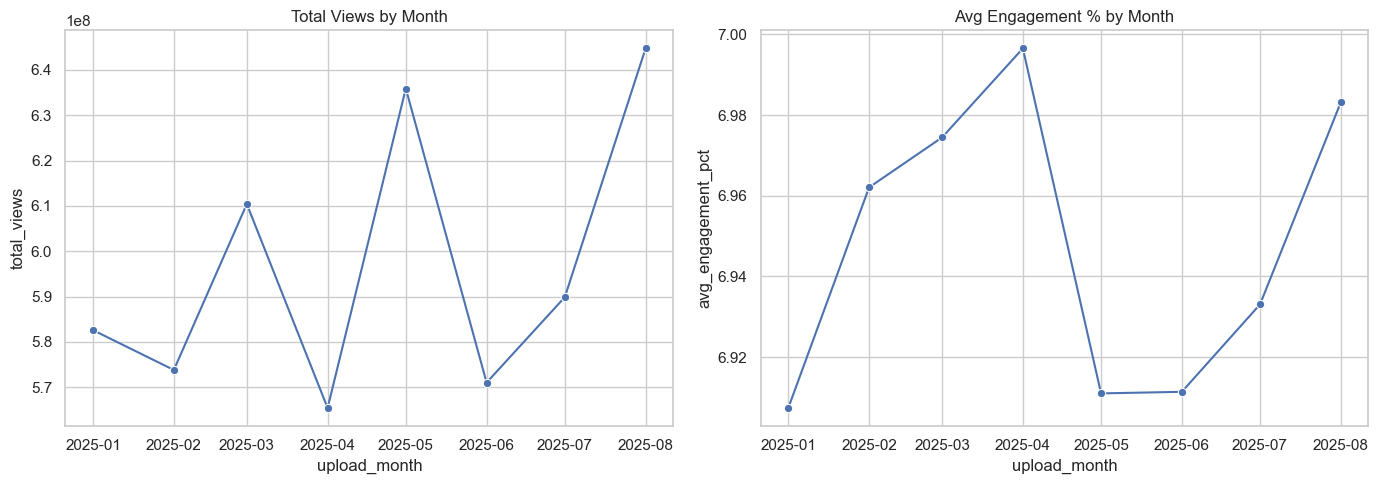

In [29]:
if 'upload_month' in df.columns and 'views' in df.columns:
    monthly = df.groupby('upload_month').agg(
        total_views=('views','sum'),
        avg_engagement_pct=('engagement_rate_pct','mean'),
        videos=('views','count')
    ).reset_index()
    monthly['upload_month'] = monthly['upload_month'].dt.to_timestamp()
    display(monthly.head())

    # Plot total views over time
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    sns.lineplot(data=monthly, x='upload_month', y='total_views', marker='o', ax=ax[0])
    ax[0].set_title('Total Views by Month')
    sns.lineplot(data=monthly, x='upload_month', y='avg_engagement_pct', marker='o', ax=ax[1])
    ax[1].set_title('Avg Engagement % by Month')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot compute monthly trends (missing upload_month or views).")


**Display a correlation heatmap for numeric columns if there are at least 2; otherwise, print a message**

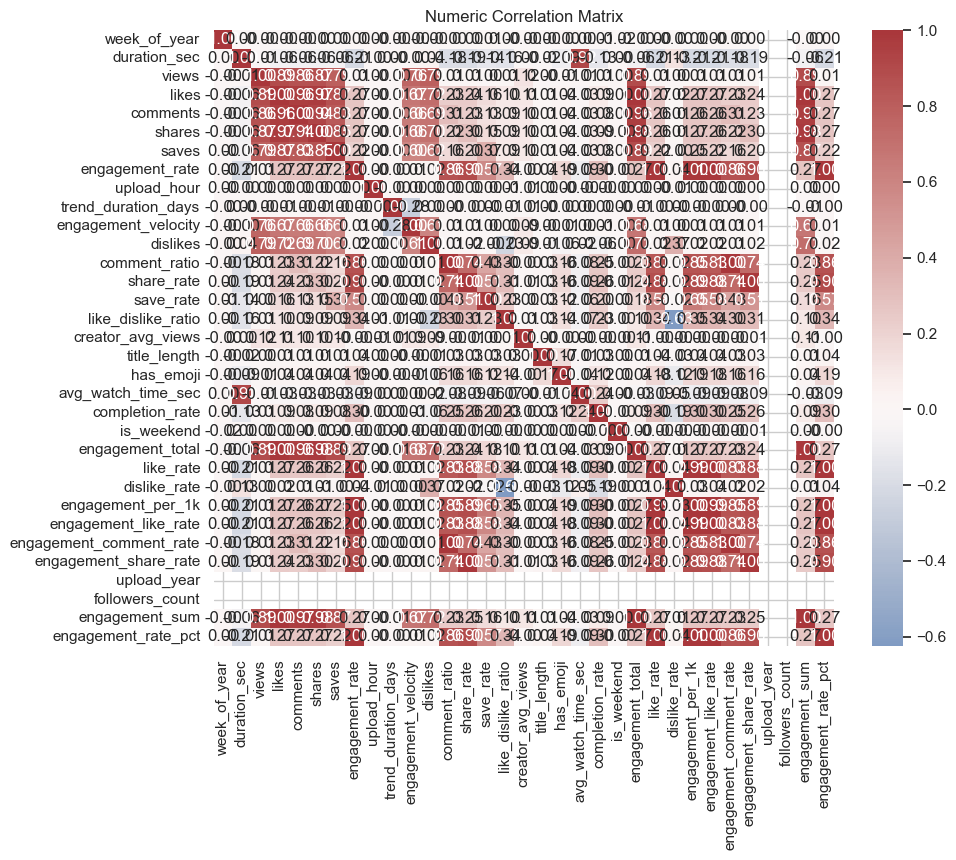

In [30]:
num_df = df.select_dtypes(include=[np.number]).copy()
if num_df.shape[1] >= 2:
    corr = num_df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
    plt.title('Numeric Correlation Matrix')
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")


**Detect videos with unusually high views using simple IQR method and display top outliers**


In [46]:
# Example: identify videos with unusually high views relative to median (simple IQR)
if 'views' in df.columns:
    q1 = df['views'].quantile(0.25)
    q3 = df['views'].quantile(0.75)
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr
    outliers = df[df['views'] > threshold]
    print(f"Views outliers count: {len(outliers)} (threshold={threshold})")
    display(outliers[[c for c in ['video_id','platform','views','likes','comments','engagement_rate_pct'] if c in outliers.columns]].head(20))
else:
    print("No 'views' column to detect outliers.")


Views outliers count: 3695 (threshold=249752.5)


,platform,views,likes,comments
0,TikTok,252497,21755,3170
1,TikTok,270580,23080,2124
12,TikTok,481882,35108,4168
14,TikTok,808842,48714,4590
43,TikTok,721155,62777,8235
45,TikTok,364512,36382,5225
54,TikTok,391195,33885,4954
69,TikTok,278417,20772,1849
92,YouTube,527421,17552,1540
112,YouTube,805234,39064,4006


**Compare row counts and key stats (views, engagement_rate) across multiple processed datasets; skipped if only one dataset**


In [32]:
# If multiple processed datasets exist, compare their row counts and key stats
if len(processed_dfs) > 1:
    compare = []
    for name, df_ in processed_dfs.items():
        n = len(df_)
        avg_views = pd.to_numeric(df_.get('views', pd.Series(dtype=float))).mean()
        avg_eng = pd.to_numeric(df_.get('engagement_rate', pd.Series(dtype=float))).mean()
        compare.append({'file': name, 'rows': n, 'avg_views': avg_views, 'avg_engagement': avg_eng})
    compare_df = pd.DataFrame(compare).sort_values('rows', ascending=False)
    display(compare_df)
else:
    print("Only one processed dataset loaded; per-file comparison skipped.")


,file,rows,avg_views,avg_engagement
5,youtube_shorts_tiktok_trends_2025_cleaned,48079,9.929276e+04,0.075415
3,top_creators_impact_2025_cleaned,1000,4.355216e+06,NaN
2,monthly_trends_2025_cleaned,480,9.945618e+06,NaN
4,top_hashtags_2025_cleaned,82,6.018525e+07,NaN
0,country_platform_summary_2025_cleaned,60,NaN,NaN
1,data_dictionary_cleaned,58,NaN,NaN


**Saved dataset, platform, and monthly summary CSVs to data/outputs/**

In [47]:
# Save a few summary CSVs to data/outputs/
try:
    # main summary stats
    stats_out = {
        'dataset': main_name,
        'rows': df.shape[0],
        'cols': df.shape[1],
        'null_total': int(df.isnull().sum().sum())
    }
    pd.DataFrame([stats_out]).to_csv(OUTPUTS_DIR / f"summary_dataset_{main_name}.csv", index=False)

    # platform summary
    if platform_col and 'views' in df.columns:
        plat = df.groupby(platform_col).agg(videos=('views','count'),
                                           total_views=('views','sum'),
                                           avg_views=('views','mean'),
                                           median_eng_pct=('engagement_rate_pct','median')).reset_index()
        plat.to_csv(OUTPUTS_DIR / "platform_summary.csv", index=False)

    # monthly summary
    if 'upload_month' in df.columns:
        monthly.to_csv(OUTPUTS_DIR / "monthly_summary.csv", index=False)

    print("Saved outputs to", OUTPUTS_DIR)
except Exception as e:
    print("Error saving outputs:", e)


Error saving outputs: "Column(s) ['engagement_rate_pct'] do not exist"
